In [124]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math
from datetime import timedelta, datetime

# Bad Predictions, OK EVAL Metrics, Work on Prediciton function

In [125]:
def prepare_lstm_data(df, target_col='Close', sequence_length=60):
    """
    Prepare data for LSTM model by creating sequences

    Parameters:
    df (DataFrame): Input dataframe with features (should have 'date' as index)
    target_col (str): Column to predict
    sequence_length (int): Number of time steps to use for sequences

    Returns:
    tuple: (X_train, y_train, X_test, y_test, scalers, feature_columns)
           Returns None for any element if preparation fails.
    """
    print("\n==== Preparing Data for LSTM Model ====")

    # Ensure the DataFrame index is a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        print("Error: DataFrame index is not a DatetimeIndex. Please set the 'date' column as the index before calling this function.")
        return None, None, None, None, None, None

    # Use the globally defined list of features
    # Ensure all selected features exist in the dataframe
    feature_columns = [col for col in FEATURES_TO_USE if col in df.columns]

    # Ensure the target column is always included in the features list
    if target_col not in feature_columns:
        if target_col in df.columns:
             feature_columns.append(target_col)
        else:
             print(f"Error: Target column '{target_col}' not found in the DataFrame.")
             return None, None, None, None, None, None

    # Check for any specified features that are missing from the DataFrame
    missing_features = [col for col in FEATURES_TO_USE if col not in df.columns]
    if missing_features:
        print(f"Warning: The following specified features are missing from the DataFrame: {missing_features}")
        # The feature_columns list already excludes these, so no further action needed here

    if not feature_columns:
         print("Error: No valid features selected or found in the DataFrame. Exiting data preparation.")
         return None, None, None, None, None, None


    print(f"Using {len(feature_columns)} features: {feature_columns[:10]}...") # Print more features for clarity

    # Create a new dataframe with selected features, dropping NaN rows
    # Only drop NaNs based on the selected feature columns
    data = df[feature_columns].dropna()

    # Check if enough data remains after dropping NaNs
    if len(data) < sequence_length + 1:
         print(f"Error: Not enough data ({len(data)} rows) after dropping NaNs to create sequences of length {sequence_length}.")
         return None, None, None, None, None, None

    # Split into training and test sets (70% train, 30% test)
    train_size = int(len(data) * 0.7)
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]

    # Check if train/test sets are large enough to create at least one sequence
    if len(train_data) < sequence_length or len(test_data) < sequence_length:
        print(f"Error: Not enough data in train ({len(train_data)}) or test ({len(test_data)}) set after splitting to create sequences of length {sequence_length}.")
        return None, None, None, None, None, None


    print(f"Train data shape: {train_data.shape}, Test data shape: {test_data.shape}")

    # Normalize the data - store scalers for later inverse transformation
    scalers = {}
    train_scaled = pd.DataFrame(index=train_data.index) # Preserve index
    test_scaled = pd.DataFrame(index=test_data.index) # Preserve index

    for column in feature_columns:
        scaler = MinMaxScaler(feature_range=(0, 1))
        # Fit scaler on training data
        train_scaled[column] = scaler.fit_transform(train_data[column].values.reshape(-1, 1)).flatten()
        # Transform test data with the same scaler
        test_scaled[column] = scaler.transform(test_data[column].values.reshape(-1, 1)).flatten()
        # Store scaler for inverse transformation later
        scalers[column] = scaler

    # Create sequences for LSTM
    def create_sequences(data, seq_length):
        X, y = [], []
        # Use .values to work with numpy arrays for sequence creation
        data_values = data.values
        # Find the index of the target column in the current data_values array
        # This is important because the order of columns in 'data' might differ from FEATURES_TO_USE
        try:
            target_idx_in_values = data.columns.get_loc(target_col)
        except KeyError:
             print(f"Error: Target column '{target_col}' not found in the DataFrame slice used for sequence creation.")
             return np.array([]), np.array([]) # Return empty arrays on error


        for i in range(len(data_values) - seq_length):
            # Extract sequence of features (from i up to i + seq_length - 1)
            seq_x = data_values[i:(i + seq_length)]
            # Extract target (the target value at the end of the sequence + 1, i.e., at index i + seq_length)
            seq_y = data_values[i + seq_length, target_idx_in_values] # Get target from the next time step
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)

    # Generate training sequences
    X_train, y_train = create_sequences(train_scaled, sequence_length)
    # Generate test sequences
    X_test, y_test = create_sequences(test_scaled, sequence_length)

    # Check if sequences were created successfully
    if X_train.shape[0] == 0 or X_test.shape[0] == 0:
         print(f"Error: Sequence creation failed. X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
         return None, None, None, None, None, None


    print(f"Training sequences shape: {X_train.shape}")
    print(f"Test sequences shape: {X_test.shape}")

    return X_train, y_train, X_test, y_test, scalers, feature_columns

In [126]:
def evaluate_model(model, X_train, y_train, X_test, y_test, scalers, target_col='Close'):
    """
    Evaluate the LSTM model performance

    Parameters:
    model: Trained LSTM model
    X_train, y_train, X_test, y_test: Training and test data
    scalers (dict): Dictionary of scalers for each feature
    target_col (str): Target column name

    Returns:
    tuple: (train_predictions, test_predictions, metrics)
           Returns None for any element if evaluation fails.
    """
    print("\n==== Evaluating Model Performance ====")

    if model is None:
        print("Error: Model is not trained. Cannot evaluate.")
        return None, None, None

    # Get target scaler for inverse transformation
    if target_col not in scalers:
        print(f"Error: Scaler for target column '{target_col}' not found.")
        return None, None, None
    scaler = scalers[target_col]

    # Make predictions
    train_predictions_scaled = model.predict(X_train)
    test_predictions_scaled = model.predict(X_test)

    # Inverse transform predictions and actual values to original scale
    train_predictions = scaler.inverse_transform(train_predictions_scaled)
    test_predictions = scaler.inverse_transform(test_predictions_scaled)

    # Transform the original y values back to original scale
    y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate metrics - make sure arrays are the same length
    # Ensure shapes match before calculating metrics
    if y_train_orig.shape != train_predictions.shape:
         print(f"Warning: Train actual ({y_train_orig.shape}) and prediction ({train_predictions.shape}) shapes mismatch. Truncating.")
         min_len = min(y_train_orig.shape[0], train_predictions.shape[0])
         y_train_orig = y_train_orig[:min_len]
         train_predictions = train_predictions[:min_len]

    if y_test_orig.shape != test_predictions.shape:
         print(f"Warning: Test actual ({y_test_orig.shape}) and prediction ({test_predictions.shape}) shapes mismatch. Truncating.")
         min_len = min(y_test_orig.shape[0], test_predictions.shape[0])
         y_test_orig = y_test_orig[:min_len]
         test_predictions = test_predictions[:min_len]


    train_rmse = math.sqrt(mean_squared_error(y_train_orig, train_predictions))
    test_rmse = math.sqrt(mean_squared_error(y_test_orig, test_predictions))

    train_mae = mean_absolute_error(y_train_orig, train_predictions)
    test_mae = mean_absolute_error(y_test_orig, test_predictions)

    train_r2 = r2_score(y_train_orig, train_predictions)
    test_r2 = r2_score(y_test_orig, test_predictions)

    # Store metrics in dictionary
    metrics = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2
    }

    # Print metrics
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Training MAE: {train_mae:.2f}")
    print(f"Test MAE: {test_mae:.2f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    return train_predictions, test_predictions, metrics

In [127]:
def visualize_predictions(df, train_predictions, test_predictions, future_predictions=None, future_dates=None, sequence_length=60, target_col='Close', history=None):
    """
    Visualize model predictions against actual prices, including future predictions

    Parameters:
    df (DataFrame): Original dataframe (before sequence creation/dropping NaNs, with DatetimeIndex)
    train_predictions, test_predictions: Model predictions (original scale)
    future_predictions (array): Predictions for future dates (original scale)
    future_dates (array): Future dates for predictions
    sequence_length (int): Sequence length used for LSTM
    target_col (str): Target column name
    history: Training history
    """
    print("\n==== Visualizing Predictions ====")

    if not isinstance(df.index, pd.DatetimeIndex):
        print("Error: DataFrame index is not a DatetimeIndex. Cannot visualize.")
        return

    plt.figure(figsize=(16, 8))

    # Plot actual data - use the original dataframe index
    plt.plot(df.index, df[target_col], color='blue', label=f'Actual {target_col} Price')

    # Calculate indices for predictions
    # We need the index of the data used for training and testing *after* dropping NaNs
    # Find the first non-NaN row in the original dataframe for the selected features
    # Use the global FEATURES_TO_USE list to determine which columns were used
    data_for_plotting = df[FEATURES_TO_USE].dropna()
    first_valid_index = data_for_plotting.index[0]

    # Find the split point index in the data_for_plotting index
    train_size_after_dropna = int(len(data_for_plotting) * 0.7)

    # The index where training predictions start (after the first sequence)
    # The training predictions correspond to the dates from sequence_length to train_size_after_dropna - 1
    if len(data_for_plotting) > sequence_length:
        train_predictions_start_index = data_for_plotting.index[sequence_length]
        train_predictions_end_index = data_for_plotting.index[train_size_after_dropna -1] # Last date of y_train
    else:
        train_predictions_start_index = None
        train_predictions_end_index = None


    # The index where test predictions start
    # The test predictions correspond to the dates from train_size_after_dropna + sequence_length to end
    if len(data_for_plotting) > train_size_after_dropna + sequence_length:
         test_predictions_start_index = data_for_plotting.index[train_size_after_dropna + sequence_length]
         test_predictions_end_index = data_for_plotting.index[-1] # Last date of y_test
    else:
         test_predictions_start_index = None
         test_predictions_end_index = None


    # Get the actual date indices for plotting
    train_plot_dates = pd.Index([]) # Initialize as empty
    if train_predictions_start_index is not None and train_predictions_end_index is not None:
         train_plot_dates = data_for_plotting.loc[train_predictions_start_index:train_predictions_end_index].index


    test_plot_dates = pd.Index([]) # Initialize as empty
    if test_predictions_start_index is not None and test_predictions_end_index is not None:
         test_plot_dates = data_for_plotting.loc[test_predictions_start_index:test_predictions_end_index].index


    # Plot training predictions
    if len(train_plot_dates) > 0 and train_predictions is not None and len(train_predictions) > 0:
        # Ensure lengths match
        min_len = min(len(train_plot_dates), len(train_predictions))
        plt.plot(train_plot_dates[:min_len], train_predictions[:min_len].flatten(),
                 color='green', label='Training Predictions')
    else:
        print("Warning: Not enough data or predictions to plot training predictions.")


    # Plot test predictions
    if len(test_plot_dates) > 0 and test_predictions is not None and len(test_predictions) > 0:
         # Ensure lengths match
        min_len = min(len(test_plot_dates), len(test_predictions))
        plt.plot(test_plot_dates[:min_len], test_predictions[:min_len].flatten(),
                 color='red', label='Test Predictions')
    else:
        print("Warning: Not enough data or predictions to plot test predictions.")


    # Plot future predictions if available
    if future_predictions is not None and future_dates is not None and len(future_dates) > 0 and len(future_predictions) > 0:
        plt.plot(future_dates, future_predictions.flatten(), color='purple', linestyle='--', linewidth=2,
                 label='Future Predictions')
    else:
        print("Warning: Future predictions or dates not available/empty. Skipping future prediction plot.")


    # Use the global stock ticker and title for chart titles
    stock_ticker = GLOBAL_STOCK_TICKER
    base_title = GLOBAL_STOCK_TITLE

    plt.title(f'{stock_ticker} {target_col} Price Prediction')
    plt.xlabel('Date')
    plt.ylabel(f'{target_col} Price ($)')
    plt.legend()
    plt.grid(True)

    # Format x-axis dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6)) # Adjusted interval for better readability
    plt.gcf().autofmt_xdate()

    # Save the prediction chart with the ticker in the filename
    plt.savefig(f'{stock_ticker}_stock_prediction_with_future.png')
    plt.show()

    # Plot loss during training if history is available
    if history is not None:
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{stock_ticker} Model Loss During Training') # Add ticker to title
        plt.xlabel('Epochs')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)

        # Save the loss chart with the ticker in the filename
        plt.savefig(f'{stock_ticker}_training_loss.png')
        plt.show()

In [128]:
def predict_future(model, df, scalers, feature_columns, target_col='Close', sequence_length=60, days_to_predict=365):
    """
    Predict future values using the trained LSTM model

    Parameters:
    model: Trained LSTM model
    df (DataFrame): Original dataframe with features (before sequence creation/dropping NaNs, with DatetimeIndex)
    scalers (dict): Dictionary of scalers for each feature
    feature_columns (list): List of feature column names used in the model
    target_col (str): Target column name to predict
    sequence_length (int): Number of time steps for sequences
    days_to_predict (int): Number of days to predict into the future

    Returns:
    tuple: (future_predictions, future_dates)
           Returns None for any element if prediction fails.
    """
    print(f"\n==== Predicting {days_to_predict} Days into the Future for {GLOBAL_STOCK_TICKER} ====")

    if model is None:
        print("Error: Model is not trained. Cannot predict future.")
        return None, None

    # Use the data that was actually used for training/testing (after dropping NaNs)
    # Ensure these columns exist in the original df
    valid_feature_columns = [col for col in feature_columns if col in df.columns]
    if not valid_feature_columns:
        print("Error: None of the specified feature columns found in the input DataFrame for future prediction.")
        return None, None

    data_for_prediction = df[valid_feature_columns].dropna()

    # Check if enough data remains after dropping NaNs
    if len(data_for_prediction) < sequence_length:
        print(f"Error: Not enough data ({len(data_for_prediction)} rows) to create the initial sequence of length {sequence_length} for future prediction.")
        return None, None

    # Create a copy of the last sequence_length records from the cleaned data
    latest_data = data_for_prediction.tail(sequence_length).copy()

    # Scale the data using the saved scalers
    latest_data_scaled = pd.DataFrame()
    for column in valid_feature_columns: # Use valid_feature_columns here
        if column in scalers:
            scaler = scalers[column]
            latest_data_scaled[column] = scaler.transform(latest_data[column].values.reshape(-1, 1)).flatten()
        else:
            print(f"Warning: Scaler for column '{column}' not found. Skipping scaling for this column in future prediction.")
            # If a scaler is missing, the prediction might be inaccurate.
            # Depending on the feature, you might need a different strategy.
            # For now, we'll just use the original value, which might not be ideal.
            latest_data_scaled[column] = latest_data[column].values.flatten()


    # Get target scaler for inverse transform
    if target_col not in scalers:
        print(f"Error: Scaler for target column '{target_col}' not found for inverse transformation.")
        return None, None
    target_scaler = scalers[target_col]

    # Generate future dates - start from the day *after* the last date in the original data
    if not df.empty:
        last_date_in_data = df.index[-1]
        future_dates = [last_date_in_data + timedelta(days=i+1) for i in range(days_to_predict)]
    else:
        print("Error: Original DataFrame is empty. Cannot generate future dates.")
        return None, None


    # Make future predictions one day at a time
    future_predictions = []

    # Create a copy of the latest scaled data for iterative prediction
    current_sequence_scaled = latest_data_scaled.values.copy()

    # Find the index of the target column in the valid_feature_columns list
    try:
        target_idx_in_features = valid_feature_columns.index(target_col)
    except ValueError:
        print(f"Error: Target column '{target_col}' not found in valid_feature_columns list.")
        return None, None


    for i in range(days_to_predict):
        # Reshape for LSTM model (samples, time steps, features)
        X_pred = current_sequence_scaled.reshape(1, sequence_length, len(valid_feature_columns)) # Use length of valid features

        # Predict next day (scaled)
        next_day_scaled = model.predict(X_pred, verbose=0) # Set verbose to 0 to reduce output during prediction loop

        # Inverse transform to get actual price
        next_day_price = target_scaler.inverse_transform(next_day_scaled)
        future_predictions.append(next_day_price[0, 0])

        # For the next iteration, update the sequence by removing the first row and adding the new prediction
        # Create a new row with all features for the predicted day
        new_row_scaled = np.zeros(len(valid_feature_columns)) # Use length of valid features

        # Set the target value (scaled) to the predicted scaled value
        new_row_scaled[target_idx_in_features] = next_day_scaled[0, 0]

        # For other features, use the scaled values from the last known data point in the sequence
        # A more advanced approach might involve predicting other features or using external data
        for j, col in enumerate(valid_feature_columns): # Iterate through valid features
            if col != target_col:
                new_row_scaled[j] = current_sequence_scaled[-1, j]

        # Update the sequence: remove first row and add new prediction row
        current_sequence_scaled = np.vstack([current_sequence_scaled[1:], new_row_scaled])

    # Convert future predictions to numpy array
    future_predictions = np.array(future_predictions).reshape(-1, 1)

    # Create a dataframe with future predictions
    future_df = pd.DataFrame({
        'Date': future_dates,
        f'Predicted_{target_col}': future_predictions.flatten()
    })
    future_df.set_index('Date', inplace=True)

    # Save future predictions to CSV with the ticker in the filename
    output_filename = f'{GLOBAL_STOCK_TICKER}_future_predictions.csv'
    try:
        future_df.to_csv(output_filename)
        print(f"Future predictions saved to '{output_filename}'")
    except Exception as e:
        print(f"Error saving future predictions to {output_filename}: {e}")


    return future_predictions, future_dates


In [129]:
def predict_lstm(df, target_col='Close', sequence_length=60, epochs=50, batch_size=32, predict_days=365):
    """
    Main function to run LSTM prediction on stock data and predict future values

    Parameters:
    df (DataFrame): Processed dataframe with features (should have 'date' as index)
    target_col (str): Column to predict (default: 'Close')
    sequence_length (int): Number of time steps for sequences (default: 60)
    epochs (int): Maximum training epochs (default: 50)
    batch_size (int): Training batch size (default: 32)
    predict_days (int): Number of days to predict into the future (default: 365)

    Returns:
    tuple: (model, metrics, predictions, future_predictions, future_dates)
           Returns None for any element if a critical error occurs.
    """
    # Ensure the DataFrame index is a DatetimeIndex before proceeding
    if not isinstance(df.index, pd.DatetimeIndex):
        print("Error: DataFrame index is not a DatetimeIndex. Please set the 'date' column as the index.")
        return None, None, None, None, None


    # Prepare data
    X_train, y_train, X_test, y_test, scalers, feature_columns = prepare_lstm_data(
        df, target_col=target_col, sequence_length=sequence_length
    )

    # Check if data preparation was successful
    if X_train is None or y_train is None or X_test is None or y_test is None or scalers is None or feature_columns is None:
         print("Data preparation failed. Exiting prediction process.")
         return None, None, None, None, None


    # Train model
    model, history = train_lstm_model(
        X_train, y_train, X_test, y_test,
        epochs=epochs, batch_size=batch_size
    )

    # Check if model training was successful
    if model is None:
         print("Model training failed. Exiting prediction process.")
         return None, None, None, None, None


    # Evaluate model
    train_predictions, test_predictions, metrics = evaluate_model(
        model, X_train, y_train, X_test, y_test, scalers, target_col
    )

    # Check if evaluation was successful
    if train_predictions is None or test_predictions is None or metrics is None:
         print("Model evaluation failed. Exiting prediction process.")
         return model, None, None, None, None # Return model if trained, but no metrics/predictions


    # Predict future values
    future_predictions, future_dates = predict_future(
        model, df, scalers, feature_columns, # Pass feature_columns from prepare_lstm_data
        target_col=target_col, sequence_length=sequence_length, days_to_predict=predict_days
    )

    # Visualize results including future predictions
    # Pass the original DataFrame 'df' for correct date indexing in visualization
    visualize_predictions(
        df, train_predictions, test_predictions,
        future_predictions, future_dates,
        sequence_length, target_col, history
    )

    # Save model with the ticker in the filename
    model_filename = f'{GLOBAL_STOCK_TICKER}_lstm_model.h5'
    try:
        model.save(model_filename)
        print(f"Model saved as '{model_filename}'")
    except Exception as e:
        print(f"Error saving model to {model_filename}: {e}")


    # Create a combined dataset with historical and future predictions
    # Use the original dataframe's index for historical data
    historical_actual = df[[target_col]].copy()
    historical_actual.columns = [f'Actual_{target_col}'] # Use target_col in column name

    # Create a dataframe for future predictions
    if future_predictions is not None and future_dates is not None:
        future_df = pd.DataFrame({
            f'Predicted_{target_col}': future_predictions.flatten() # Use target_col in column name
        }, index=future_dates)

        # Combine historical and future data
        combined_df = pd.concat([historical_actual, future_df])
        combined_output_filename = f'{GLOBAL_STOCK_TICKER}_historical_and_future.csv'
        try:
            combined_df.to_csv(combined_output_filename)
            print(f"Combined historical and future predictions saved to '{combined_output_filename}'")
        except Exception as e:
            print(f"Error saving combined data to {combined_output_filename}: {e}")
    else:
        print("Skipping saving combined historical and future data due to failed future prediction.")
        combined_df = historical_actual # Only historical data available


    return model, metrics, test_predictions, future_predictions, future_dates

Attempting to load processed data for LSTM prediction from: merged_dataset_AAPL.csv
Data loaded successfully and 'date' column set as DatetimeIndex.
Loaded data shape: (1153, 40)
Loaded data columns: ['calendarYear', 'period', 'revenue', 'grossProfit', 'netIncome', 'operatingIncome', 'eps', 'epsdiluted', 'researchAndDevelopmentExpenses', 'operatingExpenses', 'grossProfitRatio', 'operatingIncomeRatio', 'netIncomeRatio', 'weightedAverageShsOutDil', 'Close', 'High', 'Low', 'Open', 'Volume', 'days_since_financial_update', 'price_change_pct', 'price_change', 'MA_5', 'MA_10', 'MA_20', 'MA_50', 'MA_200', 'RSI', 'returns', 'volatility_5d', 'volatility_10d', 'volatility_20d', 'PE_ratio', 'volume_change', 'volume_ma_5', 'momentum_5d', 'momentum_10d', 'momentum_20d', 'market_cap', 'price_to_sales']
Loaded data index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

Processed data loaded successfully. Running LSTM prediction.

==== Preparing Data for LSTM Model ====
Using 20 features: [

C:\Users\lukis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        14,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,701 (139.46 KB)

 Trainable params: 35,701 (139.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1448 - val_loss: 0.1202
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0218 - val_loss: 0.1163
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0126 - val_loss: 0.0930
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0088 - val_loss: 0.0849
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0090 - val_loss: 0.0901
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0076 - val_loss: 0.0695
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0075 - val_loss: 0.0712
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0077 - val_loss: 0.0501
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0065 - val_loss: 0.0607
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0066 - val_loss: 0.0519
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0066 - val_loss: 0.0361
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0

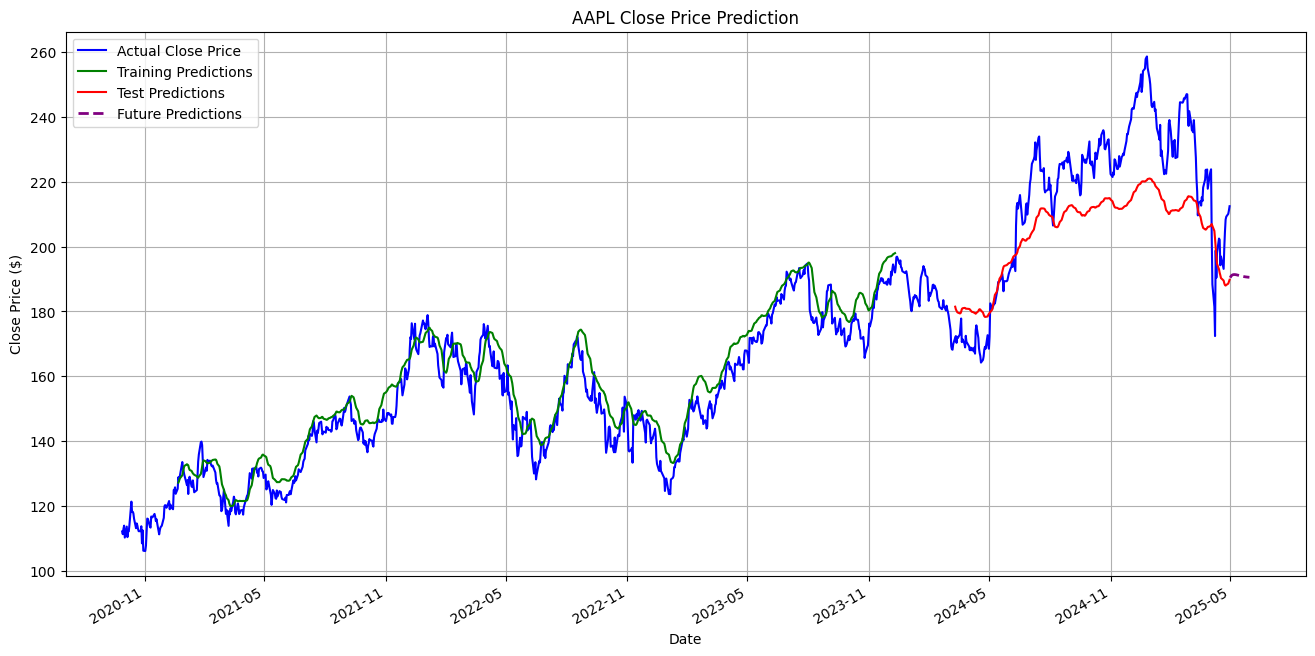

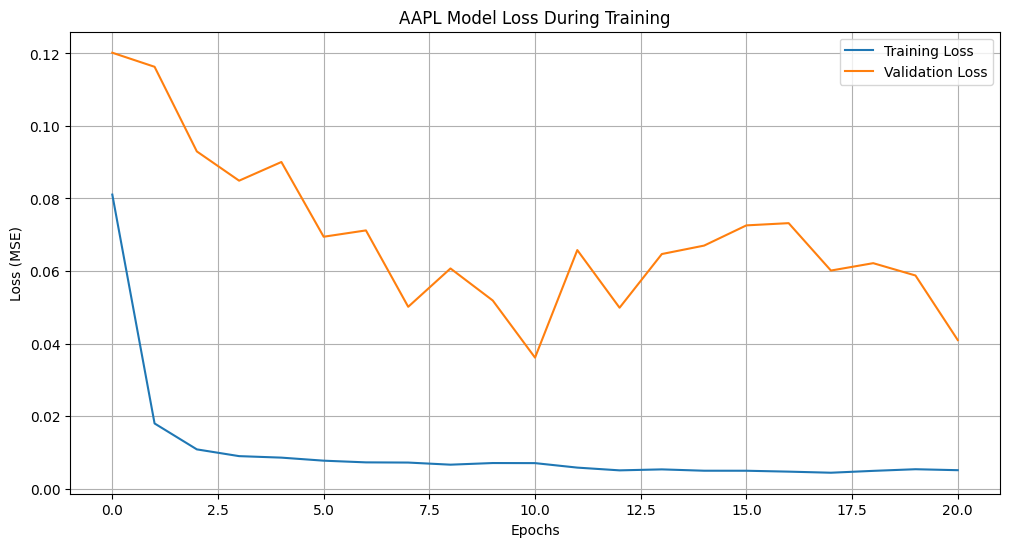

Model saved as 'AAPL_lstm_model.h5'
Combined historical and future predictions saved to 'AAPL_historical_and_future.csv'

==== Prediction Complete ====
Model metrics for AAPL: {'train_rmse': 6.251989193280844, 'test_rmse': 16.85895844939586, 'train_mae': 5.109283917081084, 'test_mae': 14.53541676981465, 'train_r2': 0.8986316147086506, 'test_r2': 0.5077940736932134}
Test predictions shape: (286, 1)
Future predictions shape: (30, 1)
Predicted 30 days into the future


In [130]:
# Example usage with the processed dataframe
if __name__ == "__main__":
    # --- Update file paths and global variables here ---
    # Set the global ticker and title
    GLOBAL_STOCK_TICKER = "AAPL" # Example: Change to "AAPL" for Apple
    GLOBAL_STOCK_TITLE = "Stock Analysis" # Can keep generic or make specific

    # Define the list of features to use for the LSTM model
    # You can easily add or remove features from this list
    # Ensure 'date' is NOT in this list as it's used as the index
    # Ensure the target column ('Close' by default) is also included in this list
    FEATURES_TO_USE = [
        'Open', 'High', 'Low', 'Close', 'Volume', # Core stock prices/volume
        'revenue', 'netIncome',    # Key financial metrics
        'eps',
        'grossProfitRatio', 'operatingIncomeRatio', 'netIncomeRatio',
        'weightedAverageShsOutDil', # Needed for price-to-sales
        'days_since_financial_update', # Days since last financial report
        'MA_50', 'MA_200', # Longer-term Moving Averages
        'RSI', # Relative Strength Index
        'volatility_20d', # Longer-term Volatility
        'PE_ratio', # Price-to-Earnings
        'volume_ma_5', # Volume metrics
        'price_to_sales', # Price-to-Sales
        # Removed: 'calendarYear', 'grossProfit', 'operatingIncome', 'epsdiluted',
        # 'MA_5', 'MA_10', 'MA_20', 'volatility_5d', 'volatility_10d', 'volume_change',
        # 'price_change_pct', 'price_change', 'returns', 'momentum_5d', 'momentum_10d', 'momentum_20d'
    ]


    # --- Load the already processed merged dataset ---
    # Make sure you have run the EDA script first to generate this file.
    # The filename is expected to include the ticker based on the EDA script's saving logic.
    merged_data_path = f"merged_dataset_{GLOBAL_STOCK_TICKER}.csv"


    print(f"Attempting to load processed data for LSTM prediction from: {merged_data_path}")

    try:
        # --- MODIFICATION START ---
        # Explicitly specify CSV reading parameters
        enhanced_df = pd.read_csv(
            merged_data_path,
            sep=',',           # Delimiter is comma
            encoding='utf-8',  # Standard encoding
            decimal='.',       # Decimal separator is a dot
            header=0,          # Header is in the first row (index 0)
            index_col='date',  # Use the 'date' column as the index
            parse_dates=True   # Automatically parse the index as dates
        )
        # --- MODIFICATION END ---

        # Check if the index is a DatetimeIndex after loading
        if isinstance(enhanced_df.index, pd.DatetimeIndex):
            print("Data loaded successfully and 'date' column set as DatetimeIndex.")
            print(f"Loaded data shape: {enhanced_df.shape}")
            print(f"Loaded data columns: {enhanced_df.columns.tolist()}")
            print(f"Loaded data index type: {type(enhanced_df.index)}")
        else:
             print("Error: 'date' column was not successfully set as a DatetimeIndex during loading.")
             # Fallback: try converting after loading if index_col didn't work as expected
             if 'date' in enhanced_df.columns:
                  enhanced_df['date'] = pd.to_datetime(enhanced_df['date'])
                  enhanced_df.set_index('date', inplace=True)
                  if isinstance(enhanced_df.index, pd.DatetimeIndex):
                       print("Successfully set 'date' column as DatetimeIndex after loading.")
                       print(f"Loaded data shape: {enhanced_df.shape}")
                       print(f"Loaded data columns: {enhanced_df.columns.tolist()}")
                       print(f"Loaded data index type: {type(enhanced_df.index)}")
                  else:
                       print("Critical Error: Could not set 'date' column as DatetimeIndex. Cannot proceed with LSTM.")
                       enhanced_df = None # Set to None to indicate failure
             else:
                  print("Critical Error: 'date' column not found in the loaded CSV. Cannot proceed with LSTM.")
                  enhanced_df = None # Set to None to indicate failure


    except FileNotFoundError:
        print(f"Error: Merged data file not found at {merged_data_path}.")
        print("Please ensure you have run the EDA script first to generate this file.")
        enhanced_df = None # Set to None to indicate failure
    except Exception as e:
        print(f"An error occurred while loading the merged data: {e}")
        # Print traceback for more detailed error information
        import traceback
        traceback.print_exc()
        enhanced_df = None # Set to None to indicate failure


    if enhanced_df is not None and not enhanced_df.empty:
        print("\nProcessed data loaded successfully. Running LSTM prediction.")

        # Run LSTM prediction with future forecasting
        # Adjust sequence_length, epochs, batch_size, predict_days as needed
        model, metrics, test_predictions, future_predictions, future_dates = predict_lstm(
            enhanced_df,
            target_col='Close',
            sequence_length=60, # Number of past days to look at for prediction
            epochs=50, # Maximum training epochs
            batch_size=32,
            predict_days=30 # Number of future days to predict
        )

        if metrics is not None:
            print("\n==== Prediction Complete ====")
            print(f"Model metrics for {GLOBAL_STOCK_TICKER}: {metrics}")
            if test_predictions is not None:
                 print(f"Test predictions shape: {test_predictions.shape}")
            if future_predictions is not None:
                 print(f"Future predictions shape: {future_predictions.shape}")
                 print(f"Predicted {len(future_dates)} days into the future")
        else:
             print(f"\nLSTM prediction process failed for {GLOBAL_STOCK_TICKER}.")

    else:
        print(f"\nSkipping LSTM prediction due to data loading or preparation errors for {GLOBAL_STOCK_TICKER}.")

In [ ]:
# Potential changes


# %%
# Potential improvements (suggestions, NOT implemented in the code above):

# 1. Hyperparameter Tuning:
#    - Use techniques like Grid Search or Random Search with cross-validation
#      to find optimal values for sequence_length, LSTM units, dropout rates,
#      batch size, and learning rate.

# 2. Feature Engineering:
#    - Explore other potentially useful features:
#      - Lagged financial metrics (e.g., revenue from 1 quarter ago)
#      - Macroeconomic indicators (interest rates, inflation)
#      - Sentiment analysis scores from news or social media
#      - Industry-specific metrics
#    - Consider transforming features (e.g., using log returns as suggested,
#      or applying other transformations like differencing).

# 3. Model Architecture:
#    - Experiment with different LSTM architectures:
#      - More or fewer LSTM layers
#      - Bidirectional LSTMs
#      - Adding other layers like Convolutional layers (CNN-LSTM) for pattern recognition
#      - Attention mechanisms to focus on important time steps

# 4. Time Series Cross-Validation:
#    - Instead of a simple train/test split, use time series cross-validation
#      (e.g., expanding window or sliding window) to get a more robust estimate
#      of model performance on unseen future data.

# 5. Ensemble Methods:
#    - Train multiple LSTM models with different architectures or features
#      and combine their predictions.

# 6. Handling Financial Data Frequency:
#    - The current approach forward-fills financial data. Consider alternative ways
#      to incorporate lower-frequency financial data into high-frequency stock data,
#      such as using financial data as static features for the period, or using
#      more sophisticated merging techniques.

# 7. Prediction Strategy:
#    - The current future prediction is iterative (predict one day, add to sequence, predict next).
#      This can suffer from accumulating errors. Explore multi-step forecasting strategies
#      where the model predicts multiple future steps at once.

# 8. Robust Scaling:
#    - While MinMaxScaler is common, consider using RobustScaler if your data
#      contains significant outliers.

# 9. Incorporate External Events:
#    - Major news events, earnings announcements, or market shocks can significantly
#      impact stock prices. Incorporating these as external features or using event-aware
#      models could improve predictions.

# 10. Different Loss Functions:
#     - Experiment with different loss functions beyond MSE, such as Mean Absolute Error (MAE)
#       or Huber loss, which might be less sensitive to outliers.

